## Alcohol Sales Example

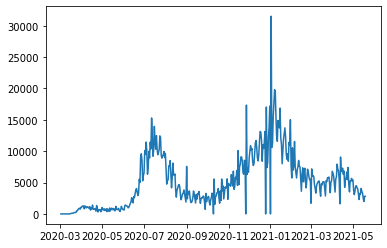

In [1]:
##### import stuff ###### 
import numpy as np 
import pandas as pd 
from covid19dh import covid19
from datetime import date
from Get_covid_data import get_data
import pymc3 as pm
import pandas as pd 
import numpy as np 
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import os 
import theano
import theano.tensor as tt 
import random
import fns as f
pd.options.mode.chained_assignment = None  # default='warn'

In [20]:
class Pycipio():
    def __init__(self, data, other_preds = None):
        self.data = data
        self.other_preds = other_preds
        
    def rename_cols(self, date, y):
        self.data = self.data.rename(
            columns = {y: "y",
                      date: "date"})
        
        self.data["date"] = pd.to_datetime(self.data["date"])
        self.data["date_idx"] = list(range(len(self.data["date"])))
        
    @staticmethod
    def scalar(df, df_ref): 
        df['y_scaled'] = df['y'] / df_ref['y'].max()
        df['t'] = (df['date'] - df_ref['date'].min()) / (df_ref['date'].max() - df_ref['date'].min())
        df.reset_index()
        return(df)
    
    def train_test_split(self, train_size):
        
        #split dataframes
        self.train, self.test = f.train_test(self.data, 
                                             "date_idx", 
                                             train_size = train_size)
        
        #scale values
        self.train = self.scalar(self.train, self.train)
        self.test = self.scalar(self.test, self.train)
        
        #init values
        self.time_train = self.train["date_idx"].values
        self.y_train = self.train["y_scaled"].values
        self.time_test = self.test["date_idx"].values
        self.y_test = self.test["y_scaled"].values
        
        #true values
        self.y_train_true = self.train["y"].values
        self.y_test_true = self.test["y"].values
    
    def seasonality_values(self, n=2, p_week=7, p_month=30, seasonality_prior_scale=2):
        self.n = n
        self.p_week = p_week
        self.p_month = p_month
        self.c_week = (2 * np.pi * np.arange(1, n + 1) / p_week)[:, None]
        self.c_month = (2 * np.pi * np.arange(1, n + 1) / p_month)[:, None]
        self.seasonality_prior_scale = seasonality_prior_scale
    
    def define_model(self, alpha_sd, beta_sd):
        with pm.Model() as m: 
    
            # shared 
            t_shared = pm.Data('t_shared', self.time_train)

            # creating fourier
            x_week = self.c_week * t_shared
            x_month = self.c_month * t_shared

            x_week_waves = tt.concatenate((tt.cos(x_week), tt.sin(x_week)), axis=0)
            x_month_waves = tt.concatenate((tt.cos(x_month), tt.sin(x_month)), axis = 0)

            # beta
            beta_week_waves = pm.Normal('beta_week_waves', mu = 0, sd = self.seasonality_prior_scale, shape = 2*self.n) 
            beta_month_waves = pm.Normal('beta_month_waves', mu = 0, sd = self.seasonality_prior_scale, shape = 2*self.n)
            beta_line = pm.Normal('beta_line', mu = 0, sd = beta_sd)

            #alpha
            alpha = pm.Normal('alpha', mu = 0, sd = alpha_sd)


            # mu temp
            mu_week_waves = pm.math.dot(x_week_waves.T, beta_week_waves) 
            mu_month_waves = pm.math.dot(x_month_waves.T, beta_month_waves)

            # multiplicative

            mu_week_waves = mu_week_waves * t_shared 
            mu_line = alpha + beta_line * t_shared

            # mu = tt.sum(mu_tmp)
            mu = mu_week_waves + mu_month_waves + mu_line

            # sigma 
            sigma = pm.HalfCauchy('sigma', 0.5)

            # likelihood 
            y_pred = pm.Normal('y_pred', 
                               mu = mu,
                               sd = sigma,
                               observed = self.y_train)
        
        self.model = m
        
    def sample_model(self):
        # idata
        with self.model: 
            self.m_idata = pm.sample(return_inferencedata = True,
                                 draws = 500,
                                    target_accept = 0.97)
            self.m_pred = pm.sample_posterior_predictive(self.m_idata,
                                            samples = 500,
                                            var_names = ["y_pred"])
    
    def plot_model_trace(self):
        az.plot_trace(self.m_idata)
        
    def predict(self):
        # predict 
        with self.model:
            pm.set_data({"t_shared": self.time_test})
            self.m_new_pred = pm.fast_sample_posterior_predictive(
                self.m_idata.posterior
            )
            
        ## RESCALE
            
        self.m_new_pred["y_pred"] = self.m_new_pred["y_pred"] * self.train['y'].max()
        self.m_pred["y_pred"] = self.m_pred["y_pred"] * self.train['y'].max()

        # mean from some axis?
        self.y_mean_test = self.m_new_pred["y_pred"].mean(axis = 0) # mean over 400 draws
        self.y_std_test = self.m_new_pred["y_pred"].std(axis = 0)

        self.y_mean_train = self.m_pred["y_pred"].mean(axis = 0) # mean over 400 draws
        self.y_std_train = self.m_pred["y_pred"].std(axis = 0)
        
    def plot_predictions(self):
        # plot them 
        fig, ax = plt.subplots(figsize = (18, 10))
        ax.plot(self.time_train, self.y_train_true, label = "data", linewidth = 1.5)
        ax.plot(self.time_test, self.y_mean_test, label = "prediction", ls = "-.", color = "C3", linewidth = 2)
        ax.fill_between(self.time_test, 
                        self.y_mean_test -1.96 * self.y_std_test, 
                        self.y_mean_test + 1.96 * self.y_std_test, 
                        alpha=0.3, 
                        label = "95% confidence interval",
                        color = "C3")
        ax.fill_between(self.time_train, 
                        self.y_mean_train - 1.96 * self.y_std_train, 
                        self.y_mean_train + 1.96 * self.y_std_train, 
                        alpha=0.3,
                       color = "C3")
        #az.plot_hdi(time_train, m_pred["y_pred"], hdi_prob = .95)
        #az.plot_hdi(time_test, m_new_pred["y_pred"], hdi_prob = .95)
        ax.axvline(len(self.time_train), ls='--', label = "train test split", color = "black")
        ax.plot(self.time_test, self.y_test_true, color = "C0", linewidth = 1.5)
        ax.plot(self.time_train, self.y_mean_train, ls="-.", color = "C3", linewidth = 2)
        ax.grid()
        ax.legend()
        #plt.show();

        ## NOTE: Can we get dates on x instead?
        
    def plot_predictions_date(self):
        # plot them 
        fig, ax = plt.subplots(figsize = (18, 10))
        ax.plot(self.train["date"].values, self.y_train_true, label = "data", linewidth = 1.5)
        ax.plot(self.test["date"].values, self.y_mean_test, label = "prediction", ls = "-.", color = "C3", linewidth = 2)
        ax.fill_between(self.test["date"], 
                        self.y_mean_test -1.96 * self.y_std_test, 
                        self.y_mean_test + 1.96 * self.y_std_test, 
                        alpha=0.3, 
                        label = "95% confidence interval",
                        color = "C3")
        ax.fill_between(self.train["date"].values, 
                        self.y_mean_train - 1.96 * self.y_std_train, 
                        self.y_mean_train + 1.96 * self.y_std_train, 
                        alpha=0.3,
                       color = "C3")
        #az.plot_hdi(time_train, m_pred["y_pred"], hdi_prob = .95)
        #az.plot_hdi(time_test, m_new_pred["y_pred"], hdi_prob = .95)
        ax.axvline(self.train["date"].values[-1], ls='--', label = "train test split", color = "black")
        ax.plot(self.test["date"], self.y_test_true, color = "C0", linewidth = 1.5)
        ax.plot(self.train["date"], self.y_mean_train, ls="-.", color = "C3", linewidth = 2)
        
        ### FPP3 PREDICTIONS INCLUDED:
        #NOTE: Should probably be in its own function, so as to easily match colors
        for i, ele in enumerate(list(set(self.other_preds["Model"]))): #HARDCODED ATM
            subset = self.other_preds[self.other_preds["Model"] == ele]
            date, preds, sd = subset["date"].values, subset["mu"].values, subset["sigma"].values
            
            ax.plot(date, preds, linewidth = 1.5, label = ele, color = f"C{3+i}")
            ax.fill_between(date, 
                        preds - 1.96 * sd, 
                        preds + 1.96 * sd, 
                        alpha=0.3,
                           color = f"C{3+i}")
        
        ax.grid()
        ax.legend()
    
    def make_pipeline(self, dictionary):
        self.rename_cols(date = dictionary["date"], y = dictionary["y"])
        self.train_test_split(dictionary["train_size"])
        self.seasonality_values(dictionary["n"], dictionary["p_week"], dictionary["p_month"], dictionary["seasonality_prior_scale"])
        self.define_model(dictionary["alpha_sd"], dictionary["beta_sd"])
        self.sample_model()
        self.predict()
        self.plot_predictions_date()
        

        
    

In [21]:
fppt3_predicts = pd.read_csv("../data/fpp3_alcohol_predictions.csv")

In [22]:
fppt3_predicts = fppt3_predicts.rename(columns = 
                                       {"Unnamed: 0": "Model",
                                        ".model": "date",
                                       })[["Model", "date", "mu", "sigma"]]

In [23]:
fppt3_predicts["date"] = pd.to_datetime(fppt3_predicts["date"])

In [24]:
fppt3_predicts_subset = fppt3_predicts[fppt3_predicts["Model"].isin(["ets", "sNAIVE", "Arima"])]

In [25]:
Pc = Pycipio(pd.read_csv("../data/archive/Alcohol_Sales.csv"), fppt3_predicts_subset)

In [26]:
specify_dict = {"date": "DATE",
               "y": "S4248SM144NCEN",
               "train_size": 0.75,
               "n": 6,
               "p_week": 12,
               "p_month": 30,
               "seasonality_prior_scale": 1.5,
               "alpha_sd": 1,
               "beta_sd": 1}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_line, beta_month_waves, beta_week_waves]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 185 seconds.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


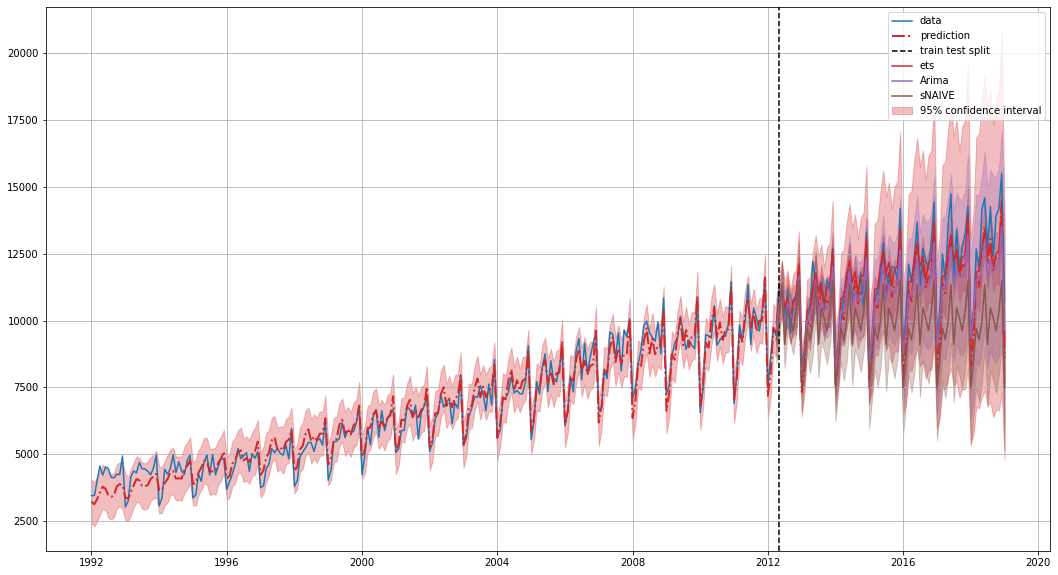

In [27]:
Pc.make_pipeline(specify_dict)

## Without the class

In [ ]:
df = pd.read_csv("../data/archive/Alcohol_Sales.csv")

In [ ]:
df = df.rename(columns = {"S4248SM144NCEN": "y", "DATE": "date"})

In [ ]:
df['date'] = pd.to_datetime(df['date'])

## train/test
import fns as f
df["date_idx"] = list(range(len(df.date)))
train, test = f.train_test(df, "date_idx", train_size = .75)

# Scale the data
def scalar(df, df_ref): 
    df['y_scaled'] = df['y'] / df_ref['y'].max()
    df['t'] = (df['date'] - df_ref['date'].min()) / (df_ref['date'].max() - df_ref['date'].min())
    df.reset_index()
    return(df)

# scale both train & test
train = scalar(train, train)
test = scalar(test, train)

## take out variables ##
time_train = train.date_idx.values
y_train = train.y_scaled.values
time_test = test.date_idx.values
y_test = test.y_scaled.values

###### Run on own data ######
n = 2
p_week = 12
p_month = 30
c_week = (2 * np.pi * np.arange(1, n + 1) / p_week)[:, None]
c_month = (2 * np.pi * np.arange(1, n + 1) / p_month)[:, None]
seasonality_prior_scale=2

with pm.Model() as m: 
    
    # shared 
    t_shared = pm.Data('t_shared', time_train)
    
    # creating fourier
    x_week = c_week * t_shared
    x_month = c_month * t_shared
    
    x_week_waves = tt.concatenate((tt.cos(x_week), tt.sin(x_week)), axis=0)
    x_month_waves = tt.concatenate((tt.cos(x_month), tt.sin(x_month)), axis = 0)
    
    # beta
    beta_week_waves = pm.Normal('beta_week_waves', mu = 0, sd = seasonality_prior_scale, shape = 2*n) 
    beta_month_waves = pm.Normal('beta_month_waves', mu = 0, sd = seasonality_prior_scale, shape = 2*n)
    beta_line = pm.Normal('beta_line', mu = 0, sd = 0.1)
    
    #alpha
    alpha = pm.Normal('alpha', mu = 0, sd = 0.5)
    
    
    # mu temp
    mu_week_waves = pm.math.dot(x_week_waves.T, beta_week_waves) 
    mu_month_waves = pm.math.dot(x_month_waves.T, beta_month_waves)
    
    # multiplicative
    
    mu_week_waves = mu_week_waves * t_shared 
    mu_line = alpha + beta_line * t_shared
    
    # mu = tt.sum(mu_tmp)
    mu = mu_week_waves + mu_month_waves + mu_line
    
    # sigma 
    sigma = pm.HalfCauchy('sigma', 0.5)
    
    # likelihood 
    y_pred = pm.Normal('y_pred', 
                       mu = mu,
                       sd = sigma,
                       observed = y_train)
    

In [ ]:
# idata
with m: 
    m_idata = pm.sample(return_inferencedata = True,
                         draws = 500)
    
# ooookay..
az.plot_trace(m_idata)

In [ ]:
# predictive
with m: 
    m_pred = pm.sample_posterior_predictive(m_idata,
                                            samples = 500,
                                            var_names = ["y_pred"])

In [ ]:
# predict 
with m:
    pm.set_data({"t_shared": time_test})
    m_new_pred = pm.fast_sample_posterior_predictive(
        m_idata.posterior
    )

# mean from some axis?
y_mean_test = m_new_pred["y_pred"].mean(axis = 0) # mean over 400 draws
y_std_test = m_new_pred["y_pred"].std(axis = 0)

y_mean_train = m_pred["y_pred"].mean(axis = 0) # mean over 400 draws
y_std_train = m_pred["y_pred"].std(axis = 0)

In [ ]:
# plot them 
fig, ax = plt.subplots(figsize = (18, 10))
ax.plot(time_train, y_train, label = "data", linewidth = 1.5)
ax.plot(time_test, y_mean_test, label = "prediction", ls = "-.", color = "C3", linewidth = 2)
ax.fill_between(time_test, 
                y_mean_test -1.96 * y_std_test, 
                y_mean_test + 1.96 * y_std_test, 
                alpha=0.3, 
                label = "95% confidence interval",
                color = "C3")
ax.fill_between(time_train, 
                y_mean_train - 1.96 * y_std_train, 
                y_mean_train + 1.96 * y_std_train, 
                alpha=0.3,
               color = "C3")
#az.plot_hdi(time_train, m_pred["y_pred"], hdi_prob = .95)
#az.plot_hdi(time_test, m_new_pred["y_pred"], hdi_prob = .95)
ax.axvline(len(time_train), ls='--', label = "train test split", color = "black")
ax.plot(time_test, y_test, color = "C0", linewidth = 1.5)
ax.plot(time_train, y_mean_train, ls="-.", color = "C3", linewidth = 2)
ax.grid()
ax.legend()
#plt.show();

## NOTE: Can we get dates on x instead?

# Beer Wine

In [ ]:
Pc = Pycipio(pd.read_csv("../data/archive/BeerWineLiquor.csv"))


In [ ]:
df = pd.read_csv("../data/archive/BeerWineLiquor.csv")

In [ ]:
df.head(30).plot()

In [ ]:
df.plot()

In [ ]:
df = df.rename(columns = {"beer": "y"})

In [ ]:
df['date'] = pd.to_datetime(df['date'])

## train/test
import fns as f
df["date_idx"] = list(range(len(df.date)))
train, test = f.train_test(df, "date_idx", train_size = .75)

# Scale the data
def scalar(df, df_ref): 
    df['y_scaled'] = df['y'] / df_ref['y'].max()
    df['t'] = (df['date'] - df_ref['date'].min()) / (df_ref['date'].max() - df_ref['date'].min())
    df.reset_index()
    return(df)

# scale both train & test
train = scalar(train, train)
test = scalar(test, train)

## take out variables ##
time_train = train.date_idx.values
y_train = train.y_scaled.values
time_test = test.date_idx.values
y_test = test.y_scaled.values

###### Run on own data ######
n = 4
p_week = 12
p_month = 25
c_week = (2 * np.pi * np.arange(1, n + 1) / p_week)[:, None]
c_month = (2 * np.pi * np.arange(1, n + 1) / p_month)[:, None]
seasonality_prior_scale=1.5

with pm.Model() as m1: 
    
    # shared 
    t_shared = pm.Data('t_shared', time_train)
    
    # creating fourier
    x_week = c_week * t_shared
    x_month = c_month * t_shared
    
    x_week_waves = tt.concatenate((tt.cos(x_week), tt.sin(x_week)), axis=0)
    x_month_waves = tt.concatenate((tt.cos(x_month), tt.sin(x_month)), axis = 0)
    
    # beta
    beta_week_waves = pm.Normal('beta_week_waves', mu = 0, sd = seasonality_prior_scale, shape = 2*n) 
    beta_month_waves = pm.Normal('beta_month_waves', mu = 0, sd = seasonality_prior_scale, shape = 2*n)
    beta_line = pm.Normal('beta_line', mu = 0, sd = 1)
    
    #alpha
    alpha = pm.Normal('alpha', mu = 0, sd = 1)
    
    
    # mu temp
    mu_week_waves = pm.math.dot(x_week_waves.T, beta_week_waves) 
    mu_month_waves = pm.math.dot(x_month_waves.T, beta_month_waves)
    
    # multiplicative
    
    mu_week_waves = mu_week_waves * t_shared 
    mu_line = alpha + beta_line * t_shared
    
    # mu = tt.sum(mu_tmp)
    mu = mu_week_waves + mu_line + mu_month_waves
    
    # sigma 
    sigma = pm.HalfCauchy('sigma', 0.5)
    
    # likelihood 
    y_pred = pm.Normal('y_pred', 
                       mu = mu,
                       sd = sigma,
                       observed = y_train)
    

In [ ]:
# idata
with m1: 
    m_idata = pm.sample(return_inferencedata = True,
                         draws = 500,
                       target_accept = 0.95)
    
# NOTE: Seems like some values of p (and n) are unstable. This should be trickered as a warning maybe
# NOTE: same can be said for inclusion of multiple periods
# the derivative fails, which seems to be caused by priors being too restrictive
# 
az.plot_trace(m_idata)

In [ ]:
# predictive
with m1: 
    m_pred = pm.sample_posterior_predictive(m_idata,
                                            samples = 500,
                                            var_names = ["y_pred"])

In [ ]:
# predict 
with m1:
    pm.set_data({"t_shared": time_test})
    m_new_pred = pm.fast_sample_posterior_predictive(
        m_idata.posterior
    )

# mean from some axis?
y_mean_test = m_new_pred["y_pred"].mean(axis = 0) # mean over 400 draws
y_std_test = m_new_pred["y_pred"].std(axis = 0)

y_mean_train = m_pred["y_pred"].mean(axis = 0) # mean over 400 draws
y_std_train = m_pred["y_pred"].std(axis = 0)

In [ ]:
# plot them 
fig, ax = plt.subplots(figsize = (18, 10))
ax.plot(time_train, y_train, label = "data", linewidth = 1.5)
ax.plot(time_test, y_mean_test, label = "prediction", ls = "-.", color = "C3", linewidth = 2)
ax.fill_between(time_test, 
                y_mean_test -1.96 * y_std_test, 
                y_mean_test + 1.96 * y_std_test, 
                alpha=0.3, 
                label = "95% confidence interval",
                color = "C3")
ax.fill_between(time_train, 
                y_mean_train - 1.96 * y_std_train, 
                y_mean_train + 1.96 * y_std_train, 
                alpha=0.3,
               color = "C3")
#az.plot_hdi(time_train, m_pred["y_pred"], hdi_prob = .95)
#az.plot_hdi(time_test, m_new_pred["y_pred"], hdi_prob = .95)
ax.axvline(len(time_train), ls='--', label = "train test split", color = "black")
ax.plot(time_test, y_test, color = "C0", linewidth = 1.5)
ax.plot(time_train, y_mean_train, ls="-.", color = "C3", linewidth = 2)
ax.grid()
ax.legend()
#plt.show();

## NOTE: Can we get dates on x instead?